<a href="https://colab.research.google.com/github/alucatto/AmP-vib-TransfEntrada/blob/main/Transforma%C3%A7%C3%A3o_de_dados_de_entrada_(tac_em_sen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bibliotecas

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
import time

In [2]:
import math

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Funções 

##### Pegar os arquivos dentro dos diretórios

In [ ]:
#    For the given path, get the List of all files in the directory tree 
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

###### Auxiliar 

In [ ]:
def podando_negative_frequencies(n):    
    return n[:int(np.shape(n)[0]/2)]

#### Processando os sinais


###### Definindo dicionários com pastas de leituras



In [ ]:
'''pastas_de_arquivos = { 'normal': 0.0,
                       'imbalance':0.1,
                       'horizontal-misalignment':0.2,
                      'overhang':0.3,
                      'underhang':0.4,
                      'vertical-misalignment':0.5
                    }

In [ ]:
pastas_de_arquivos = {'Baseline': 0.0,
                      'Desbalanc1LA': 0.1,
                      'Desbalanc2LOA': 0.2,
                      'DesalinhHorizLOA': 0.3}

###### Laço por todos os arquivos

In [ ]:
'''listas_de_arquivos = []
for subfolder in pastas_de_arquivos:
    lista = getListOfFiles('C:\\Users\\Murilo\\Desktop\\Mestrado\\PSI\\Trabalho FInal/'+subfolder+'/')
    listas_de_arquivos.append([[subfolder],lista])
    

In [ ]:
listas_de_arquivos = []
for subfolder in pastas_de_arquivos:
    lista = getListOfFiles('/content/drive/My Drive/Dados coletados/'+subfolder)
    listas_de_arquivos.append([[subfolder],lista])
    

## Leitura dos arquivos

In [4]:
dados1 = np.genfromtxt ('/content/drive/My Drive/Dados coletados/Desbalanc1LA/10Hz/Desbalanc1_10Hz_001.lvm', 
                       delimiter='\t', skip_header=24, encoding = "ISO-8859-1")
#dados2 = np.genfromtxt ('/content/drive/My Drive/Dados coletados/Baseline/20Hz/Normal_20Hz_001.lvm', 
                       #delimiter='\t', skip_header=24, encoding = "ISO-8859-1")

## Montar tabela

Somando o tempo do segundo ao tempo do primeiro, para dar sensação de continuação do tempo

In [ ]:
for i in range(0,dados2.shape[0]-1):
  dados2[i,1]=dados2[i,1]+dados1[35734-1,1]

Concatenação das duas planilhas com a continuação do tempo já ajustado:

O número 35734 no final do dados1 é o índice que está sincronizando a última borda de subida do primeiro conjunto de dados com o início do segundo

In [ ]:
tabela=np.concatenate((dados1[0:35734], dados2), axis=0)

## Detecção de borda de subida e conversão em rotação

Cria um array com os índices das bordas de subida

In [5]:
subida=np.flatnonzero((dados1[:-1,2] < 0.3) & (dados1[1:,2] > 0.3))+1
print(subida)

[  605  1211  1815  2420  3026  3633  4239  4845  5451  6056  6662  7268
  7873  8478  9083  9688 10293 10899 11504 12110 12715 13319 13924 14530
 15135 15741 16346 16952 17556 18160 18766 19371 19976 20579 21184 21789
 22392 22997 23601 24205 24810 25413 26018 26621 27226 27830 28434 29040
 29645 30249 30854 31459 32065 32670 33276 33882 34488 35094 35700]


Cálculo da rotação a partir das detecções de borda de subida

In [6]:
print(dados1.shape)

(35999, 11)


In [25]:
#rotacao=np.zeros(subida[subida.shape[0]-1])
rotacao=np.zeros(subida[subida.shape[0]-1]+1)

senoide=np.zeros(dados1.shape[0])

#primeiro período
for i in range (0,subida[0]):
  rotacao[i]=1/(dados1[subida[0],1]-dados1[0,1])
  senoide[i]=math.sin(2*3.1415*rotacao[i]*i)

#demais períodos
for i in range (1,subida.shape[0]):
  for j in range (subida[i-1],subida[i]):
    rotacao[j]=1/(dados1[subida[i],1]-dados1[subida[i-1],1])
    senoide[j]=math.sin(2*3.1415*rotacao[j]*j)

#arrumando ultimos pontos (estavam com nan)
for i in range(35093,subida[subida.shape[0]-1]+1): #35128 é o último valor certo
  rotacao[i]=rotacao[35093-1]
  senoide[i]=math.sin(2*3.1415*rotacao[i]*i)

print(rotacao)

[9.91738816 9.91738816 9.91738816 ... 9.9009901  9.9009901  9.9009901 ]


Gráfico para testes diversos. Ignorar.

In [8]:
print(rotacao.shape)

(35701,)


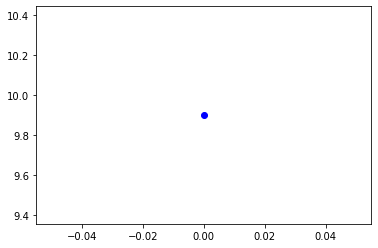

In [24]:
#plt.plot(rotacao[subida[subida.shape[0]-2]:],'bo')
plt.plot(rotacao[35093:],'bo')
#plt.plot(tabela[subida[subida.shape[0]-2]:subida[subida.shape[0]-1],2])

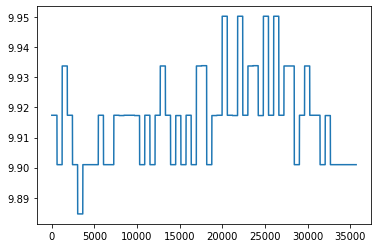

In [27]:
plt.plot(rotacao)

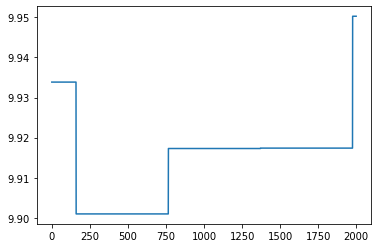

In [26]:
plt.plot(rotacao[18000:20000])

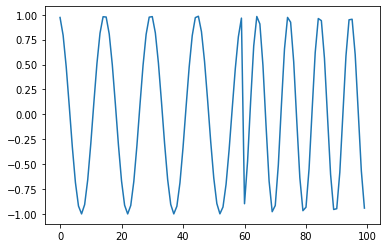

In [28]:
plt.plot(senoide[18100:18200])

In [29]:
rotacao.shape

(35701,)

In [ ]:
tabela.shape

(71733, 11)

Concatenar rotação senoidal na tabela de dados

In [30]:
tabela2 = dados1[:14500] #limitando em 14500 pontos

In [31]:
print(tabela2)

[[ 1.000000e+00  1.670000e-04  1.000000e+00 ... -1.409290e-01
   4.482210e-01 -1.522400e-01]
 [ 2.000000e+00  3.330000e-04  1.000000e+00 ... -3.515580e-01
   4.610810e-01 -5.355800e-02]
 [ 3.000000e+00  5.000000e-04  1.000000e+00 ... -5.510190e-01
   3.237110e-01  1.208210e-01]
 ...
 [ 1.449800e+04  2.416333e+00  0.000000e+00 ...  6.233500e-02
   3.079450e-01  1.465010e-01]
 [ 1.449900e+04  2.416500e+00  0.000000e+00 ...  8.286900e-02
   3.159790e-01  1.614570e-01]
 [ 1.450000e+04  2.416667e+00  0.000000e+00 ...  9.087100e-02
   3.043480e-01  1.694370e-01]]


In [32]:
tabela2.shape

(14500, 11)

In [33]:
tabela3 = np.column_stack((tabela2, senoide[:14500]))

In [34]:
print(tabela3)

[[ 1.00000000e+00  1.67000000e-04  1.00000000e+00 ...  4.48221000e-01
  -1.52240000e-01  0.00000000e+00]
 [ 2.00000000e+00  3.33000000e-04  1.00000000e+00 ...  4.61081000e-01
  -5.35580000e-02 -4.97663822e-01]
 [ 3.00000000e+00  5.00000000e-04  1.00000000e+00 ...  3.23711000e-01
   1.20821000e-01 -8.63317340e-01]
 ...
 [ 1.44980000e+04  2.41633300e+00  0.00000000e+00 ...  3.07945000e-01
   1.46501000e-01  4.80311097e-01]
 [ 1.44990000e+04  2.41650000e+00  0.00000000e+00 ...  3.15979000e-01
   1.61457000e-01  9.02242432e-01]
 [ 1.45000000e+04  2.41666700e+00  0.00000000e+00 ...  3.04348000e-01
   1.69437000e-01  9.84186041e-01]]


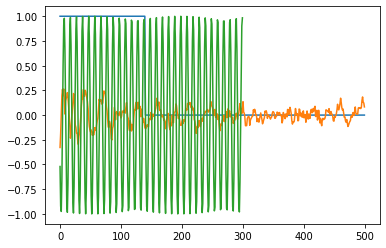

In [36]:
plt.plot(tabela3[14000:,2])
plt.plot(tabela3[14000:,6])
plt.plot(tabela3[14200:,11])

## Salvar os dados

In [38]:
np.savetxt('/content/drive/My Drive/Dados concatenados/Desb1LA_sen10Hz_001.csv',tabela3,
               delimiter=',')